<a href="https://colab.research.google.com/github/Rabbia-Ijaz/TryItOut/blob/main/TextureMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import sys
import numpy as np
import cv2
from random import randint
!pip install blend_modes
from blend_modes import soft_light
from IPython.display import display, Image


In [33]:
def Display(title1 ,a): #global display func
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/'+title1+'.jpg',a)
    print(title1)
    display(Image(filename='/content/drive/My Drive/Colab Notebooks/'+title1+'.jpg'))


# User

In [34]:
class User:         #dummy User Class
  def __init__(self, N="", I=0):
    self.Name = N
    self.ID = I
  def UserDetails(self): #displays user details
    print("Username: "+ self.Name)
    print("User ID: "+ str(self.ID))
  def returnDetails(self):
    return self.Name,self.ID

# Data Input 

In [35]:
class Data:        #Data input class
  def __init__(self, src, pat):
    self.Source = src
    self.Pattern = pat
  
  def InputData(self): #function takes source and pattern images path and return colored and grayscale images
    srcC=cv2.imread(self.Source,1)
    srcG=cv2.imread(self.Source,0)
  
    patternC=cv2.imread(self.Pattern,1)
    patternG=cv2.imread(self.Pattern,0)
    
    #dim=(srcG.shape[1],srcG.shape[0])
    dim=(315, 315)
    
    srcG=cv2.resize(srcG, dim, interpolation = cv2.INTER_AREA)
    srcC=cv2.resize(srcC, dim, interpolation = cv2.INTER_AREA)
    

    patternG=cv2.resize(patternG, dim, interpolation = cv2.INTER_AREA)
    patternC=cv2.resize(patternC, dim, interpolation = cv2.INTER_AREA)
    
    Display('image', srcC)
    Display('pattern',patternC)
    return srcC,srcG,patternC,patternG
    

# Preprocessing

In [36]:
class PreProcessing:    #Preprocessing class
  def __init__(self, srcC,srcG,patternC,patternG):
    self.srcC=srcC
    self.srcG=srcG
    self.patternC=patternC
    self.patternG=patternG

  def Thresholding(self): #this function seperates foreground from the background
    
    src2 = cv2.GaussianBlur(self.srcG,(5,5),0)
    thresh = cv2.threshold(src2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    #thresh=cv2.adaptiveThreshold(src2,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,11,2)
    #thresh = cv2.bitwise_not(thresh)
    Display("thresholded",thresh)
    return thresh

# TextureMod

In [37]:
class TextureMod:    #TextureMod model class
  def __init__(self):
    print ("The TextureMod model has been created")
  
  def Blend(self,img,pattern): #this func blends the pattern image with the source image
    dst = cv2.addWeighted(img, 0.5, pattern, 0.5, 0)
    return dst

  def Pattern(self,srcC,srcG,patternC,patternG,thresh,blend): #takes the output of Blend() and Thresholding() and returns foreground of blended image
    temp=srcC.copy()
    for i in range (0,srcG.shape[0]):
        for j in range (0, srcG.shape[1]):
            if (thresh[i][j]==0):
                temp[i][j]=blend[i][j]
            else:
                #temp[i][j]=(255,255,255)
                temp[i][j]=srcC[i][j]
                
    Display("Pattern Mapped",temp)
    return temp

  def firstMin(self,res,uniq): #returns the pixel of least occurance
    min=len(res)
    minColor=-1
    for i in range(0,len(uniq)):
      if ((res==uniq[i]).sum())< min:
        min=(res==uniq[i]).sum()
        minColor=uniq[i]
    return minColor

  def secondMin(self,res,uniq,mini): #returns the pixel of second least occurance
      min=len(res)
      minColor=-1
      for i in range(0,len(uniq)):
        if (uniq[i][0]!= mini[0] and uniq[i][1]!= mini[1] and uniq[i][2]!= mini[2]):
          if ((res==uniq[i]).sum())< min:
            min=(res==uniq[i]).sum()
            minColor=uniq[i]
      return minColor

  def KMeansAlgo(self,img,K): #this function applies Kmeans algo 
      Z = img.reshape((-1,3))
      # convert to np.float32
      Z = np.float32(Z)
      # define criteria, number of clusters(K) and apply kmeans()
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

      ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
      # Now convert back into uint8, and make original image
      center = np.uint8(center)
      res = center[label.flatten()]
      res2 = res.reshape((img.shape))
      Display('Kmeans',res2)
      return res,res2

  def FinalDetails(self,srcC,result,res,res2): #returns that image having the small details extracted by KMeans()
      result2=result.copy()
      unique_rows = np.unique(res, axis=0)
      mini1=self.firstMin(res,unique_rows)
      mini2=self.secondMin(res,unique_rows,mini1)

      for i in range(0,res2.shape[0]):
        for j in range(0,res2.shape[1]):
          if (res2[i][j][0]==mini1[0] and res2[i][j][1]==mini1[1] and res2[i][j][2]==mini1[2]) or (res2[i][j][0]==mini2[0] and res2[i][j][1]==mini2[1] and res2[i][j][2]==mini2[2]):
            result2[i][j]=srcC[i][j]
          else:
            result2[i][j]=result[i][j]
      return result2
     

# Result

In [38]:
class Result:    #Result class
  def __init__(self, img):
   self.result=img

  def showResult(self): #displays final image
    Display("FinalResult",self.result)
    

# Database

In [39]:
class Database:    #Database class
  def __init__(self, name,id):
   self.Name=name
   self.ID=id
   self.Photos=[]

  def showDatabase(self): #displays Database with respect to user name and id
    print("Name: "+ self.Name)
    print("ID: "+ str(self.ID))
    for i in range(0,len(self.Photos)):
      temp="title"+str(i)
      Display(temp,self.Photos[i])

  def AddToDatabase(self,img): #appends to database
    self.Photos.append(img)
    

# Main

image


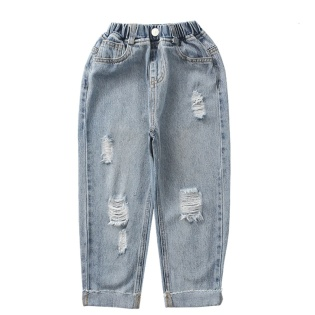

pattern


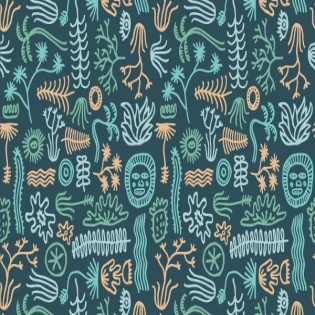

thresholded


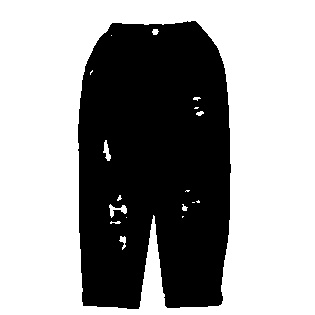

The TextureMod model has been created
Pattern Mapped


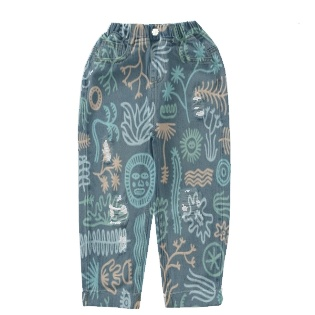

Kmeans


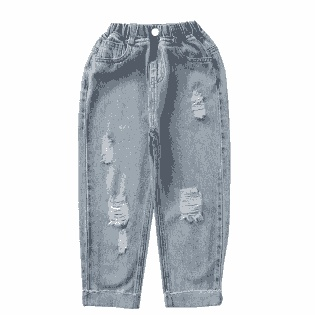

FinalResult


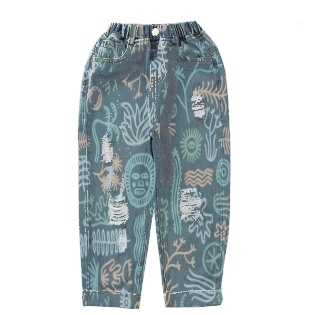

Name: Rabbia
ID: 123
title0


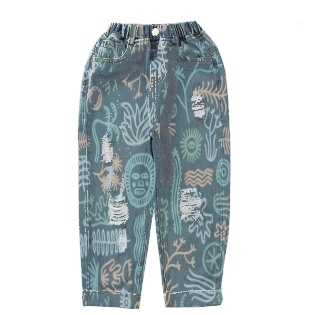

In [40]:
NewUser= User("Rabbia",123)

#NewData=Data('/content/drive/My Drive/Colab Notebooks/4.jpg','/content/drive/My Drive/Colab Notebooks/p4.jpg')
#NewData=Data('/content/drive/My Drive/Colab Notebooks/5.jpg','/content/drive/My Drive/Colab Notebooks/p5.jpg')
NewData=Data('/content/drive/My Drive/Colab Notebooks/6.jpg','/content/drive/My Drive/Colab Notebooks/p6.jpg')
#NewData=Data('/content/drive/My Drive/Colab Notebooks/7.jpg','/content/drive/My Drive/Colab Notebooks/p7.jpg')
#NewData=Data('/content/drive/My Drive/Colab Notebooks/8.jpg','/content/drive/My Drive/Colab Notebooks/p6.jpg')
#NewData=Data('/content/drive/My Drive/Colab Notebooks/9.jpg','/content/drive/My Drive/Colab Notebooks/p6.jpg')

srcC,srcG,patternC,patternG=NewData.InputData()

DataPreProcessing=PreProcessing(srcC,srcG,patternC,patternG)
thresh=DataPreProcessing.Thresholding()

TextureModel= TextureMod()
blend=TextureModel.Blend(srcC,patternC)
result=TextureModel.Pattern(srcC,srcG,patternC,patternG,thresh,blend)
res,res2=TextureModel.KMeansAlgo(srcC,6)
result=TextureModel.FinalDetails(srcC,result,res,res2)

FinalResult=Result(result)
FinalResult.showResult()

Name,ID=NewUser.returnDetails()
DB=Database(Name,ID)
DB.AddToDatabase(result)
DB.showDatabase()
